In [104]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split

In [105]:
# Configuration
RANDOM_SEED = 42
pl.seed_everything(RANDOM_SEED)

Seed set to 42


42

In [106]:
dataset_path = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.ckpt'
NUM_CLASSES = 5

In [107]:
# Load dataset
X = np.loadtxt(dataset_path, delimiter=',', dtype='float32', usecols=list(range(1, 21 * 2 + 1)))
y = np.loadtxt(dataset_path, delimiter=',', dtype='int32', usecols=(0))

In [108]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=RANDOM_SEED)

In [109]:
# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=128)

In [110]:
from torchmetrics.classification import Accuracy


In [111]:
# Lightning module
class KeypointClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(21 * 2, 20),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, NUM_CLASSES)
        )
        self.accuracy = Accuracy(task='multiclass', num_classes=NUM_CLASSES)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(logits, y)
        self.log('train_loss', loss)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(logits, y)
        self.log('val_loss', loss)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [112]:
# Initialize model
model = KeypointClassifier()

In [113]:
# Callbacks
early_stop_callback = pl.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=True)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath='model/keypoint_classifier/',
    filename='keypoint_classifier',
    save_top_k=1,
    monitor='val_loss',
    mode='min'
)

In [114]:
# Trainer
trainer = pl.Trainer(
    max_epochs=1000,
    callbacks=[early_stop_callback, checkpoint_callback],
    deterministic=True
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [115]:
# Train the model
trainer.fit(model, train_loader, val_loader)

C:\Users\houci\AppData\Local\Programs\Python\Python38\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\houci\Documents\ENSAM\3eme annee\S6\Computer Vision\CONTROLIT\model\keypoint_classifier exists and is not empty.

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | Sequential         | 1.1 K  | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


C:\Users\houci\AppData\Local\Programs\Python\Python38\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
C:\Users\houci\AppData\Local\Programs\Python\Python38\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
C:\Users\houci\AppData\Local\Programs\Python\Python38\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████████████████████████████████████████| 25/25 [00:00<00:00, 47.51it/s, v_num=17, train_acc=0.205]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|███████████████████████████████| 25/25 [00:00<00:00, 33.59it/s, v_num=17, train_acc=0.205, val_acc=0.263]

Metric val_loss improved. New best score: 1.612


Epoch 1: 100%|███████████████████████████████| 25/25 [00:00<00:00, 64.20it/s, v_num=17, train_acc=0.252, val_acc=0.263]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|███████████████████████████████| 25/25 [00:00<00:00, 44.27it/s, v_num=17, train_acc=0.252, val_acc=0.341]

Metric val_loss improved by 0.149 >= min_delta = 0.0. New best score: 1.464


Epoch 2: 100%|███████████████████████████████| 25/25 [00:00<00:00, 37.94it/s, v_num=17, train_acc=0.354, val_acc=0.341]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|███████████████████████████████| 25/25 [00:00<00:00, 29.00it/s, v_num=17, train_acc=0.354, val_acc=0.433]

Metric val_loss improved by 0.140 >= min_delta = 0.0. New best score: 1.323


Epoch 3: 100%|███████████████████████████████| 25/25 [00:00<00:00, 61.66it/s, v_num=17, train_acc=0.425, val_acc=0.433]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|███████████████████████████████| 25/25 [00:00<00:00, 42.27it/s, v_num=17, train_acc=0.425, val_acc=0.590]

Metric val_loss improved by 0.096 >= min_delta = 0.0. New best score: 1.227


Epoch 4: 100%|███████████████████████████████| 25/25 [00:00<00:00, 62.47it/s, v_num=17, train_acc=0.433, val_acc=0.590]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|███████████████████████████████| 25/25 [00:00<00:00, 45.44it/s, v_num=17, train_acc=0.433, val_acc=0.604]

Metric val_loss improved by 0.077 >= min_delta = 0.0. New best score: 1.150


Epoch 5: 100%|███████████████████████████████| 25/25 [00:00<00:00, 65.16it/s, v_num=17, train_acc=0.591, val_acc=0.604]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|███████████████████████████████| 25/25 [00:00<00:00, 45.39it/s, v_num=17, train_acc=0.591, val_acc=0.619]

Metric val_loss improved by 0.068 >= min_delta = 0.0. New best score: 1.083


Epoch 6: 100%|███████████████████████████████| 25/25 [00:00<00:00, 63.81it/s, v_num=17, train_acc=0.528, val_acc=0.619]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|███████████████████████████████| 25/25 [00:00<00:00, 45.50it/s, v_num=17, train_acc=0.528, val_acc=0.634]

Metric val_loss improved by 0.066 >= min_delta = 0.0. New best score: 1.017


Epoch 7: 100%|███████████████████████████████| 25/25 [00:00<00:00, 66.56it/s, v_num=17, train_acc=0.535, val_acc=0.634]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|███████████████████████████████| 25/25 [00:00<00:00, 47.58it/s, v_num=17, train_acc=0.535, val_acc=0.689]

Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 0.960


Epoch 8: 100%|███████████████████████████████| 25/25 [00:00<00:00, 68.35it/s, v_num=17, train_acc=0.598, val_acc=0.689]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|███████████████████████████████| 25/25 [00:00<00:00, 48.38it/s, v_num=17, train_acc=0.598, val_acc=0.699]

Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 0.903


Epoch 9: 100%|███████████████████████████████| 25/25 [00:00<00:00, 62.47it/s, v_num=17, train_acc=0.614, val_acc=0.699]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|███████████████████████████████| 25/25 [00:00<00:00, 39.42it/s, v_num=17, train_acc=0.614, val_acc=0.709]

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.857


Epoch 10: 100%|██████████████████████████████| 25/25 [00:00<00:00, 66.95it/s, v_num=17, train_acc=0.654, val_acc=0.709]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████████████████████████| 25/25 [00:00<00:00, 48.36it/s, v_num=17, train_acc=0.654, val_acc=0.741]

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 0.811


Epoch 11: 100%|██████████████████████████████| 25/25 [00:00<00:00, 71.42it/s, v_num=17, train_acc=0.646, val_acc=0.741]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████████████████████████| 25/25 [00:00<00:00, 49.20it/s, v_num=17, train_acc=0.646, val_acc=0.781]

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.769


Epoch 12: 100%|██████████████████████████████| 25/25 [00:00<00:00, 61.11it/s, v_num=17, train_acc=0.622, val_acc=0.781]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████████████████████████| 25/25 [00:00<00:00, 41.11it/s, v_num=17, train_acc=0.622, val_acc=0.784]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.731


Epoch 13: 100%|██████████████████████████████| 25/25 [00:00<00:00, 64.83it/s, v_num=17, train_acc=0.646, val_acc=0.784]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████████████████████████| 25/25 [00:00<00:00, 46.09it/s, v_num=17, train_acc=0.646, val_acc=0.791]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.702


Epoch 14: 100%|██████████████████████████████| 25/25 [00:00<00:00, 69.81it/s, v_num=17, train_acc=0.669, val_acc=0.791]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████████████████████████| 25/25 [00:00<00:00, 49.22it/s, v_num=17, train_acc=0.669, val_acc=0.798]

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.666


Epoch 15: 100%|██████████████████████████████| 25/25 [00:00<00:00, 53.67it/s, v_num=17, train_acc=0.591, val_acc=0.798]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████████████████████████| 25/25 [00:00<00:00, 39.49it/s, v_num=17, train_acc=0.591, val_acc=0.804]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.641


Epoch 16: 100%|██████████████████████████████| 25/25 [00:00<00:00, 63.90it/s, v_num=17, train_acc=0.654, val_acc=0.804]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████████████████████████| 25/25 [00:00<00:00, 41.67it/s, v_num=17, train_acc=0.654, val_acc=0.803]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.623


Epoch 17: 100%|██████████████████████████████| 25/25 [00:00<00:00, 68.25it/s, v_num=17, train_acc=0.661, val_acc=0.803]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████████████████████████| 25/25 [00:00<00:00, 49.14it/s, v_num=17, train_acc=0.661, val_acc=0.805]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.608


Epoch 18: 100%|██████████████████████████████| 25/25 [00:00<00:00, 65.18it/s, v_num=17, train_acc=0.701, val_acc=0.805]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████████████████████████| 25/25 [00:00<00:00, 46.16it/s, v_num=17, train_acc=0.701, val_acc=0.803]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.589


Epoch 19: 100%|██████████████████████████████| 25/25 [00:00<00:00, 69.73it/s, v_num=17, train_acc=0.543, val_acc=0.803]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████████████████████████| 25/25 [00:00<00:00, 50.06it/s, v_num=17, train_acc=0.543, val_acc=0.813]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.568


Epoch 20: 100%|██████████████████████████████| 25/25 [00:00<00:00, 65.28it/s, v_num=17, train_acc=0.685, val_acc=0.813]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 20: 100%|██████████████████████████████| 25/25 [00:00<00:00, 47.57it/s, v_num=17, train_acc=0.685, val_acc=0.814]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.556


Epoch 21: 100%|██████████████████████████████| 25/25 [00:00<00:00, 71.56it/s, v_num=17, train_acc=0.740, val_acc=0.814]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 21: 100%|██████████████████████████████| 25/25 [00:00<00:00, 49.20it/s, v_num=17, train_acc=0.740, val_acc=0.822]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.544


Epoch 22: 100%|██████████████████████████████| 25/25 [00:00<00:00, 62.44it/s, v_num=17, train_acc=0.693, val_acc=0.822]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 22: 100%|██████████████████████████████| 25/25 [00:00<00:00, 45.48it/s, v_num=17, train_acc=0.693, val_acc=0.822]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.529


Epoch 23: 100%|██████████████████████████████| 25/25 [00:00<00:00, 69.70it/s, v_num=17, train_acc=0.685, val_acc=0.822]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 23: 100%|██████████████████████████████| 25/25 [00:00<00:00, 49.99it/s, v_num=17, train_acc=0.685, val_acc=0.826]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.516


Epoch 24: 100%|██████████████████████████████| 25/25 [00:00<00:00, 71.41it/s, v_num=17, train_acc=0.709, val_acc=0.826]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 24: 100%|██████████████████████████████| 25/25 [00:00<00:00, 51.71it/s, v_num=17, train_acc=0.709, val_acc=0.837]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.503


Epoch 25: 100%|██████████████████████████████| 25/25 [00:00<00:00, 71.41it/s, v_num=17, train_acc=0.677, val_acc=0.837]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 25: 100%|██████████████████████████████| 25/25 [00:00<00:00, 50.93it/s, v_num=17, train_acc=0.677, val_acc=0.830]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.494


Epoch 26: 100%|██████████████████████████████| 25/25 [00:00<00:00, 67.82it/s, v_num=17, train_acc=0.717, val_acc=0.830]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 26: 100%|██████████████████████████████| 25/25 [00:00<00:00, 49.31it/s, v_num=17, train_acc=0.717, val_acc=0.844]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.491


Epoch 27: 100%|██████████████████████████████| 25/25 [00:00<00:00, 50.75it/s, v_num=17, train_acc=0.677, val_acc=0.844]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 27: 100%|██████████████████████████████| 25/25 [00:00<00:00, 37.49it/s, v_num=17, train_acc=0.677, val_acc=0.852]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.475


Epoch 28: 100%|██████████████████████████████| 25/25 [00:00<00:00, 69.83it/s, v_num=17, train_acc=0.693, val_acc=0.852]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 28: 100%|██████████████████████████████| 25/25 [00:00<00:00, 49.99it/s, v_num=17, train_acc=0.693, val_acc=0.852]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.465


Epoch 29: 100%|██████████████████████████████| 25/25 [00:00<00:00, 67.12it/s, v_num=17, train_acc=0.724, val_acc=0.852]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|██████████████████████████████| 25/25 [00:00<00:00, 46.79it/s, v_num=17, train_acc=0.724, val_acc=0.864]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.463


Epoch 30: 100%|██████████████████████████████| 25/25 [00:00<00:00, 68.29it/s, v_num=17, train_acc=0.717, val_acc=0.864]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 30: 100%|██████████████████████████████| 25/25 [00:00<00:00, 48.42it/s, v_num=17, train_acc=0.717, val_acc=0.856]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.453


Epoch 31: 100%|██████████████████████████████| 25/25 [00:00<00:00, 66.78it/s, v_num=17, train_acc=0.803, val_acc=0.856]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 31: 100%|██████████████████████████████| 25/25 [00:00<00:00, 47.68it/s, v_num=17, train_acc=0.803, val_acc=0.864]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.448


Epoch 32: 100%|██████████████████████████████| 25/25 [00:00<00:00, 69.85it/s, v_num=17, train_acc=0.803, val_acc=0.864]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 32: 100%|██████████████████████████████| 25/25 [00:00<00:00, 49.16it/s, v_num=17, train_acc=0.803, val_acc=0.868]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.442


Epoch 33: 100%|██████████████████████████████| 25/25 [00:00<00:00, 63.66it/s, v_num=17, train_acc=0.732, val_acc=0.868]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 33: 100%|██████████████████████████████| 25/25 [00:00<00:00, 43.40it/s, v_num=17, train_acc=0.732, val_acc=0.877]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.438


Epoch 34: 100%|██████████████████████████████| 25/25 [00:00<00:00, 48.44it/s, v_num=17, train_acc=0.685, val_acc=0.877]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 34: 100%|██████████████████████████████| 25/25 [00:00<00:00, 37.49it/s, v_num=17, train_acc=0.685, val_acc=0.881]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.427


Epoch 35: 100%|██████████████████████████████| 25/25 [00:00<00:00, 57.76it/s, v_num=17, train_acc=0.740, val_acc=0.881]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 35: 100%|██████████████████████████████| 25/25 [00:00<00:00, 42.40it/s, v_num=17, train_acc=0.740, val_acc=0.881]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.426


Epoch 36: 100%|██████████████████████████████| 25/25 [00:00<00:00, 66.49it/s, v_num=17, train_acc=0.701, val_acc=0.881]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 36: 100%|██████████████████████████████| 25/25 [00:00<00:00, 44.16it/s, v_num=17, train_acc=0.701, val_acc=0.880]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.420


Epoch 37: 100%|██████████████████████████████| 25/25 [00:00<00:00, 69.77it/s, v_num=17, train_acc=0.701, val_acc=0.880]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 37: 100%|██████████████████████████████| 25/25 [00:00<00:00, 49.22it/s, v_num=17, train_acc=0.701, val_acc=0.886]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.414


Epoch 38: 100%|██████████████████████████████| 25/25 [00:00<00:00, 66.36it/s, v_num=17, train_acc=0.780, val_acc=0.886]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 38: 100%|██████████████████████████████| 25/25 [00:00<00:00, 46.70it/s, v_num=17, train_acc=0.780, val_acc=0.892]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.412


Epoch 39: 100%|██████████████████████████████| 25/25 [00:00<00:00, 71.27it/s, v_num=17, train_acc=0.780, val_acc=0.892]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 39: 100%|██████████████████████████████| 25/25 [00:00<00:00, 49.13it/s, v_num=17, train_acc=0.780, val_acc=0.889]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.402


Epoch 40: 100%|██████████████████████████████| 25/25 [00:00<00:00, 69.55it/s, v_num=17, train_acc=0.701, val_acc=0.889]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 40: 100%|██████████████████████████████| 25/25 [00:00<00:00, 49.93it/s, v_num=17, train_acc=0.701, val_acc=0.897]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.399


Epoch 41: 100%|██████████████████████████████| 25/25 [00:00<00:00, 67.64it/s, v_num=17, train_acc=0.677, val_acc=0.897]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 41: 100%|██████████████████████████████| 25/25 [00:00<00:00, 47.89it/s, v_num=17, train_acc=0.677, val_acc=0.900]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.395


Epoch 42: 100%|██████████████████████████████| 25/25 [00:00<00:00, 65.30it/s, v_num=17, train_acc=0.787, val_acc=0.900]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 42: 100%|██████████████████████████████| 25/25 [00:00<00:00, 46.90it/s, v_num=17, train_acc=0.787, val_acc=0.900]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.390


Epoch 43: 100%|██████████████████████████████| 25/25 [00:00<00:00, 68.02it/s, v_num=17, train_acc=0.732, val_acc=0.900]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 43: 100%|██████████████████████████████| 25/25 [00:00<00:00, 48.83it/s, v_num=17, train_acc=0.732, val_acc=0.901]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.385


Epoch 44: 100%|██████████████████████████████| 25/25 [00:00<00:00, 66.99it/s, v_num=17, train_acc=0.748, val_acc=0.901]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 44: 100%|██████████████████████████████| 25/25 [00:00<00:00, 48.74it/s, v_num=17, train_acc=0.748, val_acc=0.903]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.380


Epoch 45: 100%|██████████████████████████████| 25/25 [00:00<00:00, 69.57it/s, v_num=17, train_acc=0.748, val_acc=0.903]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 45: 100%|██████████████████████████████| 25/25 [00:00<00:00, 44.78it/s, v_num=17, train_acc=0.748, val_acc=0.901]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.377


Epoch 46: 100%|██████████████████████████████| 25/25 [00:00<00:00, 61.09it/s, v_num=17, train_acc=0.772, val_acc=0.901]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 46: 100%|██████████████████████████████| 25/25 [00:00<00:00, 43.48it/s, v_num=17, train_acc=0.772, val_acc=0.900]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.372


Epoch 47: 100%|██████████████████████████████| 25/25 [00:00<00:00, 65.09it/s, v_num=17, train_acc=0.669, val_acc=0.900]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 47: 100%|██████████████████████████████| 25/25 [00:00<00:00, 45.26it/s, v_num=17, train_acc=0.669, val_acc=0.903]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.366


Epoch 48: 100%|██████████████████████████████| 25/25 [00:00<00:00, 52.44it/s, v_num=17, train_acc=0.803, val_acc=0.903]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 48: 100%|██████████████████████████████| 25/25 [00:00<00:00, 37.05it/s, v_num=17, train_acc=0.803, val_acc=0.901]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.358


Epoch 49: 100%|██████████████████████████████| 25/25 [00:00<00:00, 68.42it/s, v_num=17, train_acc=0.756, val_acc=0.901]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 50: 100%|██████████████████████████████| 25/25 [00:00<00:00, 68.18it/s, v_num=17, train_acc=0.819, val_acc=0.909]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 50: 100%|██████████████████████████████| 25/25 [00:00<00:00, 50.11it/s, v_num=17, train_acc=0.819, val_acc=0.913]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.350


Epoch 51: 100%|██████████████████████████████| 25/25 [00:00<00:00, 56.30it/s, v_num=17, train_acc=0.764, val_acc=0.913]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 51: 100%|██████████████████████████████| 25/25 [00:00<00:00, 41.52it/s, v_num=17, train_acc=0.764, val_acc=0.918]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.346


Epoch 52: 100%|██████████████████████████████| 25/25 [00:00<00:00, 42.88it/s, v_num=17, train_acc=0.724, val_acc=0.918]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 53: 100%|██████████████████████████████| 25/25 [00:00<00:00, 53.82it/s, v_num=17, train_acc=0.654, val_acc=0.915]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 53: 100%|██████████████████████████████| 25/25 [00:00<00:00, 40.69it/s, v_num=17, train_acc=0.654, val_acc=0.919]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.345


Epoch 54: 100%|██████████████████████████████| 25/25 [00:00<00:00, 52.43it/s, v_num=17, train_acc=0.756, val_acc=0.919]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 54: 100%|██████████████████████████████| 25/25 [00:00<00:00, 39.88it/s, v_num=17, train_acc=0.756, val_acc=0.915]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.340


Epoch 55: 100%|██████████████████████████████| 25/25 [00:00<00:00, 47.03it/s, v_num=17, train_acc=0.819, val_acc=0.915]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 55: 100%|██████████████████████████████| 25/25 [00:00<00:00, 36.57it/s, v_num=17, train_acc=0.819, val_acc=0.915]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.339


Epoch 56: 100%|██████████████████████████████| 25/25 [00:00<00:00, 55.49it/s, v_num=17, train_acc=0.827, val_acc=0.915]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 56: 100%|██████████████████████████████| 25/25 [00:00<00:00, 41.58it/s, v_num=17, train_acc=0.827, val_acc=0.921]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.330


Epoch 57: 100%|██████████████████████████████| 25/25 [00:00<00:00, 65.22it/s, v_num=17, train_acc=0.677, val_acc=0.921]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 57: 100%|██████████████████████████████| 25/25 [00:00<00:00, 46.27it/s, v_num=17, train_acc=0.677, val_acc=0.918]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.327


Epoch 58: 100%|██████████████████████████████| 25/25 [00:00<00:00, 69.82it/s, v_num=17, train_acc=0.787, val_acc=0.918]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 58: 100%|██████████████████████████████| 25/25 [00:00<00:00, 48.45it/s, v_num=17, train_acc=0.787, val_acc=0.921]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.323


Epoch 59: 100%|██████████████████████████████| 25/25 [00:00<00:00, 61.26it/s, v_num=17, train_acc=0.780, val_acc=0.921]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 59: 100%|██████████████████████████████| 25/25 [00:00<00:00, 44.11it/s, v_num=17, train_acc=0.780, val_acc=0.926]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.318


Epoch 60: 100%|██████████████████████████████| 25/25 [00:00<00:00, 64.98it/s, v_num=17, train_acc=0.764, val_acc=0.926]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 60: 100%|██████████████████████████████| 25/25 [00:00<00:00, 47.46it/s, v_num=17, train_acc=0.764, val_acc=0.917]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.316


Epoch 61: 100%|██████████████████████████████| 25/25 [00:00<00:00, 65.77it/s, v_num=17, train_acc=0.803, val_acc=0.917]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 61: 100%|██████████████████████████████| 25/25 [00:00<00:00, 46.14it/s, v_num=17, train_acc=0.803, val_acc=0.918]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.313


Epoch 62: 100%|██████████████████████████████| 25/25 [00:00<00:00, 64.53it/s, v_num=17, train_acc=0.787, val_acc=0.918]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 63: 100%|██████████████████████████████| 25/25 [00:00<00:00, 67.78it/s, v_num=17, train_acc=0.740, val_acc=0.923]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 63: 100%|██████████████████████████████| 25/25 [00:00<00:00, 47.89it/s, v_num=17, train_acc=0.740, val_acc=0.923]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.308


Epoch 64: 100%|██████████████████████████████| 25/25 [00:00<00:00, 53.66it/s, v_num=17, train_acc=0.724, val_acc=0.923]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 64: 100%|██████████████████████████████| 25/25 [00:00<00:00, 40.59it/s, v_num=17, train_acc=0.724, val_acc=0.924]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.307


Epoch 65: 100%|██████████████████████████████| 25/25 [00:00<00:00, 68.25it/s, v_num=17, train_acc=0.780, val_acc=0.924]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 65: 100%|██████████████████████████████| 25/25 [00:00<00:00, 46.25it/s, v_num=17, train_acc=0.780, val_acc=0.923]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.303


Epoch 66: 100%|██████████████████████████████| 25/25 [00:00<00:00, 65.26it/s, v_num=17, train_acc=0.701, val_acc=0.923]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 67: 100%|██████████████████████████████| 25/25 [00:00<00:00, 68.12it/s, v_num=17, train_acc=0.717, val_acc=0.918]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 68: 100%|██████████████████████████████| 25/25 [00:00<00:00, 69.75it/s, v_num=17, train_acc=0.772, val_acc=0.929]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 69: 100%|██████████████████████████████| 25/25 [00:00<00:00, 69.49it/s, v_num=17, train_acc=0.764, val_acc=0.925]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 69: 100%|█████████████████████████

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.300


Epoch 70: 100%|██████████████████████████████| 25/25 [00:00<00:00, 69.90it/s, v_num=17, train_acc=0.748, val_acc=0.924]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 71: 100%|██████████████████████████████| 25/25 [00:00<00:00, 71.41it/s, v_num=17, train_acc=0.780, val_acc=0.926]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 71: 100%|██████████████████████████████| 25/25 [00:00<00:00, 49.39it/s, v_num=17, train_acc=0.780, val_acc=0.922]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.296


Epoch 72: 100%|██████████████████████████████| 25/25 [00:00<00:00, 66.10it/s, v_num=17, train_acc=0.795, val_acc=0.922]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 72: 100%|██████████████████████████████| 25/25 [00:00<00:00, 47.23it/s, v_num=17, train_acc=0.795, val_acc=0.923]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.294


Epoch 73: 100%|██████████████████████████████| 25/25 [00:00<00:00, 64.43it/s, v_num=17, train_acc=0.795, val_acc=0.923]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 73: 100%|██████████████████████████████| 25/25 [00:00<00:00, 44.17it/s, v_num=17, train_acc=0.795, val_acc=0.923]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.288


Epoch 74: 100%|██████████████████████████████| 25/25 [00:00<00:00, 68.65it/s, v_num=17, train_acc=0.795, val_acc=0.923]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 74: 100%|██████████████████████████████| 25/25 [00:00<00:00, 48.62it/s, v_num=17, train_acc=0.795, val_acc=0.927]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.283


Epoch 75: 100%|██████████████████████████████| 25/25 [00:00<00:00, 69.83it/s, v_num=17, train_acc=0.787, val_acc=0.927]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 76: 100%|██████████████████████████████| 25/25 [00:00<00:00, 69.73it/s, v_num=17, train_acc=0.787, val_acc=0.923]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 77: 100%|██████████████████████████████| 25/25 [00:00<00:00, 70.64it/s, v_num=17, train_acc=0.827, val_acc=0.926]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 78: 100%|██████████████████████████████| 25/25 [00:00<00:00, 71.17it/s, v_num=17, train_acc=0.756, val_acc=0.922]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 78: 100%|█████████████████████████

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.282


Epoch 79: 100%|██████████████████████████████| 25/25 [00:00<00:00, 71.68it/s, v_num=17, train_acc=0.756, val_acc=0.923]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 79: 100%|██████████████████████████████| 25/25 [00:00<00:00, 47.64it/s, v_num=17, train_acc=0.756, val_acc=0.922]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.279


Epoch 80: 100%|██████████████████████████████| 25/25 [00:00<00:00, 66.46it/s, v_num=17, train_acc=0.732, val_acc=0.922]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 80: 100%|██████████████████████████████| 25/25 [00:00<00:00, 48.26it/s, v_num=17, train_acc=0.732, val_acc=0.923]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.275


Epoch 81: 100%|██████████████████████████████| 25/25 [00:00<00:00, 69.96it/s, v_num=17, train_acc=0.850, val_acc=0.923]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 82: 100%|██████████████████████████████| 25/25 [00:00<00:00, 71.15it/s, v_num=17, train_acc=0.787, val_acc=0.926]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 83: 100%|██████████████████████████████| 25/25 [00:00<00:00, 62.47it/s, v_num=17, train_acc=0.827, val_acc=0.924]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 84: 100%|██████████████████████████████| 25/25 [00:00<00:00, 69.82it/s, v_num=17, train_acc=0.732, val_acc=0.926]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 85: 100%|█████████████████████████

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.273


Epoch 86: 100%|██████████████████████████████| 25/25 [00:00<00:00, 70.19it/s, v_num=17, train_acc=0.787, val_acc=0.927]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 87: 100%|██████████████████████████████| 25/25 [00:00<00:00, 71.42it/s, v_num=17, train_acc=0.795, val_acc=0.924]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 87: 100%|██████████████████████████████| 25/25 [00:00<00:00, 51.04it/s, v_num=17, train_acc=0.795, val_acc=0.927]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.269


Epoch 88: 100%|██████████████████████████████| 25/25 [00:00<00:00, 67.47it/s, v_num=17, train_acc=0.795, val_acc=0.927]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 88: 100%|██████████████████████████████| 25/25 [00:00<00:00, 48.56it/s, v_num=17, train_acc=0.795, val_acc=0.930]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.269


Epoch 89: 100%|██████████████████████████████| 25/25 [00:00<00:00, 68.22it/s, v_num=17, train_acc=0.850, val_acc=0.930]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 90: 100%|██████████████████████████████| 25/25 [00:00<00:00, 66.70it/s, v_num=17, train_acc=0.795, val_acc=0.931]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 90: 100%|██████████████████████████████| 25/25 [00:00<00:00, 46.94it/s, v_num=17, train_acc=0.795, val_acc=0.925]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.265


Epoch 91: 100%|██████████████████████████████| 25/25 [00:00<00:00, 48.44it/s, v_num=17, train_acc=0.772, val_acc=0.925]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 92: 100%|██████████████████████████████| 25/25 [00:00<00:00, 50.55it/s, v_num=17, train_acc=0.772, val_acc=0.926]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 93: 100%|██████████████████████████████| 25/25 [00:00<00:00, 59.68it/s, v_num=17, train_acc=0.772, val_acc=0.927]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 93: 100%|██████████████████████████████| 25/25 [00:00<00:00, 42.87it/s, v_num=17, train_acc=0.772, val_acc=0.933]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.265


Epoch 94: 100%|██████████████████████████████| 25/25 [00:00<00:00, 64.14it/s, v_num=17, train_acc=0.811, val_acc=0.933]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 95: 100%|██████████████████████████████| 25/25 [00:00<00:00, 35.62it/s, v_num=17, train_acc=0.835, val_acc=0.934]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 95: 100%|██████████████████████████████| 25/25 [00:01<00:00, 23.46it/s, v_num=17, train_acc=0.835, val_acc=0.937]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.261


Epoch 96: 100%|██████████████████████████████| 25/25 [00:00<00:00, 62.63it/s, v_num=17, train_acc=0.724, val_acc=0.937]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 96: 100%|██████████████████████████████| 25/25 [00:00<00:00, 43.77it/s, v_num=17, train_acc=0.724, val_acc=0.936]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.256


Epoch 97: 100%|██████████████████████████████| 25/25 [00:00<00:00, 59.51it/s, v_num=17, train_acc=0.795, val_acc=0.936]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 98: 100%|██████████████████████████████| 25/25 [00:00<00:00, 71.37it/s, v_num=17, train_acc=0.795, val_acc=0.934]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 98: 100%|██████████████████████████████| 25/25 [00:00<00:00, 47.86it/s, v_num=17, train_acc=0.795, val_acc=0.936]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.254


Epoch 99: 100%|██████████████████████████████| 25/25 [00:00<00:00, 51.76it/s, v_num=17, train_acc=0.811, val_acc=0.936]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████████████████████████| 25/25 [00:00<00:00, 37.48it/s, v_num=17, train_acc=0.811, val_acc=0.936]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.251


Epoch 100: 100%|█████████████████████████████| 25/25 [00:00<00:00, 66.70it/s, v_num=17, train_acc=0.756, val_acc=0.936]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 100: 100%|█████████████████████████████| 25/25 [00:00<00:00, 48.46it/s, v_num=17, train_acc=0.756, val_acc=0.939]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.249


Epoch 101: 100%|█████████████████████████████| 25/25 [00:00<00:00, 66.27it/s, v_num=17, train_acc=0.732, val_acc=0.939]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 102: 100%|█████████████████████████████| 25/25 [00:00<00:00, 60.52it/s, v_num=17, train_acc=0.717, val_acc=0.933]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 103: 100%|█████████████████████████████| 25/25 [00:00<00:00, 64.34it/s, v_num=17, train_acc=0.740, val_acc=0.940]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 104: 100%|█████████████████████████████| 25/25 [00:00<00:00, 60.22it/s, v_num=17, train_acc=0.764, val_acc=0.940]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 105: 100%|████████████████████████

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.248


Epoch 106: 100%|█████████████████████████████| 25/25 [00:00<00:00, 49.95it/s, v_num=17, train_acc=0.740, val_acc=0.933]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 107: 100%|█████████████████████████████| 25/25 [00:00<00:00, 52.00it/s, v_num=17, train_acc=0.764, val_acc=0.932]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 107: 100%|█████████████████████████████| 25/25 [00:00<00:00, 33.19it/s, v_num=17, train_acc=0.764, val_acc=0.942]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.246


Epoch 108: 100%|█████████████████████████████| 25/25 [00:00<00:00, 66.73it/s, v_num=17, train_acc=0.717, val_acc=0.942]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 108: 100%|█████████████████████████████| 25/25 [00:00<00:00, 46.73it/s, v_num=17, train_acc=0.717, val_acc=0.934]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.245


Epoch 109: 100%|█████████████████████████████| 25/25 [00:00<00:00, 68.15it/s, v_num=17, train_acc=0.787, val_acc=0.934]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 110: 100%|█████████████████████████████| 25/25 [00:00<00:00, 50.39it/s, v_num=17, train_acc=0.787, val_acc=0.934]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 111: 100%|█████████████████████████████| 25/25 [00:00<00:00, 68.17it/s, v_num=17, train_acc=0.772, val_acc=0.938]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 111: 100%|█████████████████████████████| 25/25 [00:00<00:00, 46.92it/s, v_num=17, train_acc=0.772, val_acc=0.941]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.245


Epoch 112: 100%|█████████████████████████████| 25/25 [00:00<00:00, 63.99it/s, v_num=17, train_acc=0.780, val_acc=0.941]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 113: 100%|█████████████████████████████| 25/25 [00:00<00:00, 64.87it/s, v_num=17, train_acc=0.677, val_acc=0.941]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 113: 100%|█████████████████████████████| 25/25 [00:00<00:00, 47.47it/s, v_num=17, train_acc=0.677, val_acc=0.938]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.241


Epoch 114: 100%|█████████████████████████████| 25/25 [00:00<00:00, 62.50it/s, v_num=17, train_acc=0.740, val_acc=0.938]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 115: 100%|█████████████████████████████| 25/25 [00:00<00:00, 68.13it/s, v_num=17, train_acc=0.795, val_acc=0.942]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 115: 100%|█████████████████████████████| 25/25 [00:00<00:00, 49.12it/s, v_num=17, train_acc=0.795, val_acc=0.938]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.239


Epoch 116: 100%|█████████████████████████████| 25/25 [00:00<00:00, 65.31it/s, v_num=17, train_acc=0.764, val_acc=0.938]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 117: 100%|█████████████████████████████| 25/25 [00:00<00:00, 70.99it/s, v_num=17, train_acc=0.795, val_acc=0.940]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 118: 100%|█████████████████████████████| 25/25 [00:00<00:00, 68.13it/s, v_num=17, train_acc=0.835, val_acc=0.935]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 119: 100%|█████████████████████████████| 25/25 [00:00<00:00, 69.71it/s, v_num=17, train_acc=0.866, val_acc=0.944]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 119: 100%|████████████████████████

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.237


Epoch 120: 100%|█████████████████████████████| 25/25 [00:00<00:00, 65.15it/s, v_num=17, train_acc=0.709, val_acc=0.948]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 120: 100%|█████████████████████████████| 25/25 [00:00<00:00, 47.59it/s, v_num=17, train_acc=0.709, val_acc=0.951]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.231


Epoch 121: 100%|█████████████████████████████| 25/25 [00:00<00:00, 66.72it/s, v_num=17, train_acc=0.764, val_acc=0.951]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 122: 100%|█████████████████████████████| 25/25 [00:00<00:00, 65.00it/s, v_num=17, train_acc=0.724, val_acc=0.938]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 123: 100%|█████████████████████████████| 25/25 [00:00<00:00, 63.76it/s, v_num=17, train_acc=0.835, val_acc=0.945]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 124: 100%|█████████████████████████████| 25/25 [00:00<00:00, 65.16it/s, v_num=17, train_acc=0.803, val_acc=0.932]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 125: 100%|████████████████████████

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.230


Epoch 133: 100%|█████████████████████████████| 25/25 [00:00<00:00, 54.74it/s, v_num=17, train_acc=0.709, val_acc=0.950]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 133: 100%|█████████████████████████████| 25/25 [00:00<00:00, 37.59it/s, v_num=17, train_acc=0.709, val_acc=0.941]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.229


Epoch 134: 100%|█████████████████████████████| 25/25 [00:00<00:00, 64.14it/s, v_num=17, train_acc=0.772, val_acc=0.941]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 134: 100%|█████████████████████████████| 25/25 [00:00<00:00, 46.89it/s, v_num=17, train_acc=0.772, val_acc=0.947]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.228


Epoch 135: 100%|█████████████████████████████| 25/25 [00:00<00:00, 69.66it/s, v_num=17, train_acc=0.827, val_acc=0.947]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 135: 100%|█████████████████████████████| 25/25 [00:00<00:00, 49.13it/s, v_num=17, train_acc=0.827, val_acc=0.944]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.227


Epoch 136: 100%|█████████████████████████████| 25/25 [00:00<00:00, 65.19it/s, v_num=17, train_acc=0.819, val_acc=0.944]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 137: 100%|█████████████████████████████| 25/25 [00:00<00:00, 69.68it/s, v_num=17, train_acc=0.787, val_acc=0.949]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 138: 100%|█████████████████████████████| 25/25 [00:00<00:00, 70.03it/s, v_num=17, train_acc=0.780, val_acc=0.949]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 139: 100%|█████████████████████████████| 25/25 [00:00<00:00, 62.60it/s, v_num=17, train_acc=0.780, val_acc=0.943]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 140: 100%|████████████████████████

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.225


Epoch 141: 100%|█████████████████████████████| 25/25 [00:00<00:00, 69.81it/s, v_num=17, train_acc=0.787, val_acc=0.947]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 141: 100%|█████████████████████████████| 25/25 [00:00<00:00, 49.85it/s, v_num=17, train_acc=0.787, val_acc=0.955]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.223


Epoch 142: 100%|█████████████████████████████| 25/25 [00:00<00:00, 61.26it/s, v_num=17, train_acc=0.835, val_acc=0.955]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 143: 100%|█████████████████████████████| 25/25 [00:00<00:00, 72.88it/s, v_num=17, train_acc=0.803, val_acc=0.949]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 143: 100%|█████████████████████████████| 25/25 [00:00<00:00, 47.60it/s, v_num=17, train_acc=0.803, val_acc=0.958]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.222


Epoch 144: 100%|█████████████████████████████| 25/25 [00:00<00:00, 66.96it/s, v_num=17, train_acc=0.772, val_acc=0.958]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 145: 100%|█████████████████████████████| 25/25 [00:00<00:00, 52.90it/s, v_num=17, train_acc=0.858, val_acc=0.953]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 146: 100%|█████████████████████████████| 25/25 [00:00<00:00, 67.90it/s, v_num=17, train_acc=0.811, val_acc=0.950]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 147: 100%|█████████████████████████████| 25/25 [00:00<00:00, 68.62it/s, v_num=17, train_acc=0.764, val_acc=0.943]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 148: 100%|████████████████████████

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.216


Epoch 152: 100%|█████████████████████████████| 25/25 [00:00<00:00, 68.04it/s, v_num=17, train_acc=0.795, val_acc=0.953]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 152: 100%|█████████████████████████████| 25/25 [00:00<00:00, 49.12it/s, v_num=17, train_acc=0.795, val_acc=0.947]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.215


Epoch 153: 100%|█████████████████████████████| 25/25 [00:00<00:00, 69.69it/s, v_num=17, train_acc=0.780, val_acc=0.947]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 154: 100%|█████████████████████████████| 25/25 [00:00<00:00, 67.66it/s, v_num=17, train_acc=0.772, val_acc=0.956]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 155: 100%|█████████████████████████████| 25/25 [00:00<00:00, 69.98it/s, v_num=17, train_acc=0.724, val_acc=0.959]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 156: 100%|█████████████████████████████| 25/25 [00:00<00:00, 66.62it/s, v_num=17, train_acc=0.724, val_acc=0.956]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 157: 100%|████████████████████████

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.213


Epoch 159: 100%|█████████████████████████████| 25/25 [00:00<00:00, 68.18it/s, v_num=17, train_acc=0.811, val_acc=0.955]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 160: 100%|█████████████████████████████| 25/25 [00:00<00:00, 66.71it/s, v_num=17, train_acc=0.803, val_acc=0.950]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 161: 100%|█████████████████████████████| 25/25 [00:00<00:00, 66.83it/s, v_num=17, train_acc=0.772, val_acc=0.957]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 161: 100%|█████████████████████████████| 25/25 [00:00<00:00, 48.38it/s, v_num=17, train_acc=0.772, val_acc=0.958]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.210


Epoch 162: 100%|█████████████████████████████| 25/25 [00:00<00:00, 51.78it/s, v_num=17, train_acc=0.835, val_acc=0.958]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 163: 100%|█████████████████████████████| 25/25 [00:00<00:00, 71.40it/s, v_num=17, train_acc=0.803, val_acc=0.959]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 164: 100%|█████████████████████████████| 25/25 [00:00<00:00, 68.27it/s, v_num=17, train_acc=0.756, val_acc=0.962]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 165: 100%|█████████████████████████████| 25/25 [00:00<00:00, 40.42it/s, v_num=17, train_acc=0.780, val_acc=0.963]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 165: 100%|████████████████████████

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.209


Epoch 166: 100%|█████████████████████████████| 25/25 [00:00<00:00, 62.71it/s, v_num=17, train_acc=0.843, val_acc=0.959]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 166: 100%|█████████████████████████████| 25/25 [00:00<00:00, 45.49it/s, v_num=17, train_acc=0.843, val_acc=0.958]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.209


Epoch 167: 100%|█████████████████████████████| 25/25 [00:00<00:00, 65.11it/s, v_num=17, train_acc=0.787, val_acc=0.958]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 168: 100%|█████████████████████████████| 25/25 [00:00<00:00, 48.73it/s, v_num=17, train_acc=0.780, val_acc=0.959]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 169: 100%|█████████████████████████████| 25/25 [00:00<00:00, 66.28it/s, v_num=17, train_acc=0.772, val_acc=0.964]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 170: 100%|█████████████████████████████| 25/25 [00:00<00:00, 66.98it/s, v_num=17, train_acc=0.835, val_acc=0.959]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 170: 100%|████████████████████████

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.208


Epoch 171: 100%|█████████████████████████████| 25/25 [00:00<00:00, 57.60it/s, v_num=17, train_acc=0.756, val_acc=0.959]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 172: 100%|█████████████████████████████| 25/25 [00:00<00:00, 66.60it/s, v_num=17, train_acc=0.780, val_acc=0.961]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 172: 100%|█████████████████████████████| 25/25 [00:00<00:00, 48.44it/s, v_num=17, train_acc=0.780, val_acc=0.963]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.203


Epoch 173: 100%|█████████████████████████████| 25/25 [00:00<00:00, 69.33it/s, v_num=17, train_acc=0.803, val_acc=0.963]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 174: 100%|█████████████████████████████| 25/25 [00:00<00:00, 69.45it/s, v_num=17, train_acc=0.827, val_acc=0.959]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 175: 100%|█████████████████████████████| 25/25 [00:00<00:00, 61.18it/s, v_num=17, train_acc=0.787, val_acc=0.959]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 176: 100%|█████████████████████████████| 25/25 [00:00<00:00, 69.85it/s, v_num=17, train_acc=0.787, val_acc=0.956]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 177: 100%|████████████████████████

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.202


Epoch 185: 100%|█████████████████████████████| 25/25 [00:00<00:00, 54.68it/s, v_num=17, train_acc=0.787, val_acc=0.956]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 186: 100%|█████████████████████████████| 25/25 [00:00<00:00, 68.25it/s, v_num=17, train_acc=0.858, val_acc=0.962]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 186: 100%|█████████████████████████████| 25/25 [00:00<00:00, 49.19it/s, v_num=17, train_acc=0.858, val_acc=0.966]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.202


Epoch 187: 100%|█████████████████████████████| 25/25 [00:00<00:00, 67.97it/s, v_num=17, train_acc=0.827, val_acc=0.966]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 188: 100%|█████████████████████████████| 25/25 [00:00<00:00, 60.04it/s, v_num=17, train_acc=0.756, val_acc=0.957]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 189: 100%|█████████████████████████████| 25/25 [00:00<00:00, 69.69it/s, v_num=17, train_acc=0.811, val_acc=0.966]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 190: 100%|█████████████████████████████| 25/25 [00:00<00:00, 66.74it/s, v_num=17, train_acc=0.787, val_acc=0.963]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 191: 100%|████████████████████████

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.200


Epoch 192: 100%|█████████████████████████████| 25/25 [00:00<00:00, 49.93it/s, v_num=17, train_acc=0.811, val_acc=0.963]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 192: 100%|█████████████████████████████| 25/25 [00:00<00:00, 37.11it/s, v_num=17, train_acc=0.811, val_acc=0.967]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.199


Epoch 193: 100%|█████████████████████████████| 25/25 [00:00<00:00, 65.15it/s, v_num=17, train_acc=0.835, val_acc=0.967]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 194: 100%|█████████████████████████████| 25/25 [00:00<00:00, 61.43it/s, v_num=17, train_acc=0.827, val_acc=0.955]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 195: 100%|█████████████████████████████| 25/25 [00:00<00:00, 67.74it/s, v_num=17, train_acc=0.811, val_acc=0.963]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 196: 100%|█████████████████████████████| 25/25 [00:00<00:00, 66.80it/s, v_num=17, train_acc=0.835, val_acc=0.961]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 197: 100%|████████████████████████

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.198


Epoch 207: 100%|█████████████████████████████| 25/25 [00:00<00:00, 56.75it/s, v_num=17, train_acc=0.787, val_acc=0.965]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 208: 100%|█████████████████████████████| 25/25 [00:00<00:00, 49.93it/s, v_num=17, train_acc=0.843, val_acc=0.964]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 208: 100%|█████████████████████████████| 25/25 [00:00<00:00, 39.01it/s, v_num=17, train_acc=0.843, val_acc=0.963]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.194


Epoch 209: 100%|█████████████████████████████| 25/25 [00:00<00:00, 64.94it/s, v_num=17, train_acc=0.835, val_acc=0.963]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 209: 100%|█████████████████████████████| 25/25 [00:00<00:00, 45.94it/s, v_num=17, train_acc=0.835, val_acc=0.964]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.192


Epoch 210: 100%|█████████████████████████████| 25/25 [00:00<00:00, 59.97it/s, v_num=17, train_acc=0.843, val_acc=0.964]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 211: 100%|█████████████████████████████| 25/25 [00:00<00:00, 69.33it/s, v_num=17, train_acc=0.787, val_acc=0.957]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 212: 100%|█████████████████████████████| 25/25 [00:00<00:00, 50.63it/s, v_num=17, train_acc=0.827, val_acc=0.965]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 213: 100%|█████████████████████████████| 25/25 [00:00<00:00, 62.40it/s, v_num=17, train_acc=0.811, val_acc=0.965]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 214: 100%|████████████████████████

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.192


Epoch 223: 100%|█████████████████████████████| 25/25 [00:00<00:00, 71.41it/s, v_num=17, train_acc=0.835, val_acc=0.963]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 224: 100%|█████████████████████████████| 25/25 [00:00<00:00, 69.60it/s, v_num=17, train_acc=0.780, val_acc=0.963]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 224: 100%|█████████████████████████████| 25/25 [00:00<00:00, 50.15it/s, v_num=17, train_acc=0.780, val_acc=0.965]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.188


Epoch 225: 100%|█████████████████████████████| 25/25 [00:00<00:00, 69.82it/s, v_num=17, train_acc=0.795, val_acc=0.965]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 226: 100%|█████████████████████████████| 25/25 [00:00<00:00, 69.95it/s, v_num=17, train_acc=0.803, val_acc=0.970]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 227: 100%|█████████████████████████████| 25/25 [00:00<00:00, 68.40it/s, v_num=17, train_acc=0.819, val_acc=0.972]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 228: 100%|█████████████████████████████| 25/25 [00:00<00:00, 71.42it/s, v_num=17, train_acc=0.819, val_acc=0.964]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 229: 100%|████████████████████████

Monitored metric val_loss did not improve in the last 20 records. Best score: 0.188. Signaling Trainer to stop.


Epoch 244: 100%|█████████████████████████████| 25/25 [00:00<00:00, 48.31it/s, v_num=17, train_acc=0.772, val_acc=0.963]


In [116]:
# Load the best model
best_model = KeypointClassifier.load_from_checkpoint(model_save_path)

In [117]:
best_model.eval()
with torch.no_grad():
    test_sample = X_test_tensor[0].unsqueeze(0)
    output = best_model(test_sample)
    probs = torch.softmax(output, dim=1)
    print(probs.squeeze().numpy())
    print(torch.argmax(probs).item())

[1.4049451e-01 7.4015995e-03 8.5059530e-01 2.4867672e-06 1.5061222e-03]
2


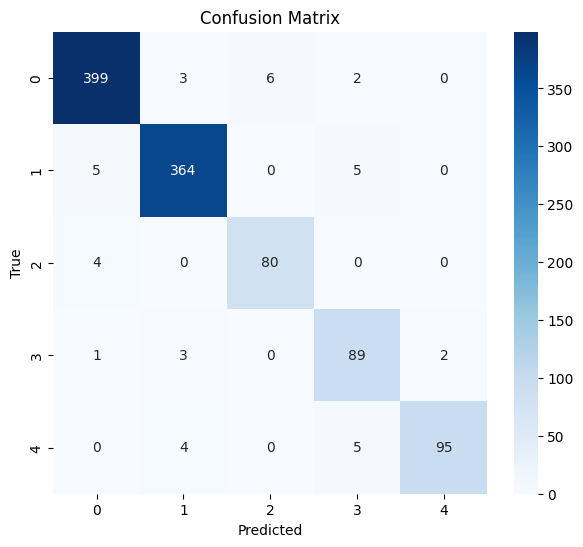

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       410
           1       0.97      0.97      0.97       374
           2       0.93      0.95      0.94        84
           3       0.88      0.94      0.91        95
           4       0.98      0.91      0.95       104

    accuracy                           0.96      1067
   macro avg       0.95      0.95      0.95      1067
weighted avg       0.96      0.96      0.96      1067



In [118]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import TensorDataset, DataLoader

# Set model to eval mode
model.eval()

# Convert test data to tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for batch prediction
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Collect predictions
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        logits = model(x)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.cpu().numpy())

# Plot confusion matrix and classification report
def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g', square=False, cmap='Blues')
    ax.set_ylim(len(labels), 0)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    plt.title("Confusion Matrix")
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

# Show results
print_confusion_matrix(all_targets, all_preds)


In [119]:
# Save only the weights
torch.save(model.state_dict(), "model/keypoint_classifier/keypoint_classifier_weights.pth")


In [120]:
from model.keypoint_classifier.keypoint_classifier_pyt import KeyPointClassifier

  # your model definition
import torch

# Rebuild the model architecture
model = KeypointClassifier()

# Load the saved weights
model.load_state_dict(torch.load("model/keypoint_classifier/keypoint_classifier_weights.pth"))
model.eval()


# Prepare input tensor (e.g., one sample from X_test)
input_tensor = torch.tensor([X_test[0]], dtype=torch.float32)

# Inference
with torch.no_grad():
    output = model(input_tensor)
    probs = torch.softmax(output, dim=1).squeeze()
    predicted_class = torch.argmax(probs).item()

# Output results
print(probs.numpy())
print(predicted_class)


[1.3644946e-01 7.0029190e-03 8.5537010e-01 2.2372842e-06 1.1752991e-03]
2


C:\Users\houci\AppData\Local\Temp\ipykernel_13940\3493685169.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/keypoint_classifier